In [ ]:
from params import *
from libraries import *
import helper_funcs
import feature_engineering
import models

# preprocessing for separate json files to collect all the data in one file

In [2]:
# # df = pretify_json_data(data_dir) # comment out because its already done || uncomment to re-run and check directory with jsons
# df = load_prettified_data()
# df = feature_engineering.explode_qualifiers(df) # this runs for 5-10 mins depending on your machine, i suggest just loading the prepared data
# df.drop(columns=['LeadingToAttempt', 'LeadingToGoal']).to_parquet('exploded_events.parquet', index=False, engine='pyarrow') # save the exploded data to parquet || dropping columns because they contain multiple data types 

# single data-read

In [3]:
df = pd.read_parquet('data/exploded_events.parquet').sort_values(['leagueSeason', 'jsonName', 'eventId'], ascending=True)

# initial EDA

In [4]:
# missing values examination || checking only original, non-engineered columns
helper_funcs.check_missing_values(df)

$len               100.000000
$idx               100.000000
isGoal              99.812390
cardType            99.744346
blockedY            99.037703
blockedX            99.037703
satisfiers          98.728268
minuteInfo          98.728268
field               98.728268
text                98.728268
isShot              98.340627
goalMouthZ          98.340627
goalMouthY          98.340627
relatedPlayerId     97.764604
relatedEventId      97.764604
endX                33.907534
endY                33.907534
dtype: float64

In [5]:
# fill NA values with 0 for all features except coordinates & coordinate-based features
df = helper_funcs.fill_na_except_coordinates(df, cols_not_to_fill, 0)

In [6]:
helper_funcs.check_missing_values(df)

endY    33.907534
endX    33.907534
dtype: float64

In [7]:
# avg number of events per json file
print(f"avg number of events per json file: {int(df.groupby('jsonName').agg({'id': 'count'}).mean().values[0])}")
print(f"avg number of passes per json file: {int(df.dropna(subset=['x', 'y', 'endX', 'endY']).groupby('jsonName').agg({'id': 'count'}).mean().values[0])}")

avg number of events per json file: 1572
avg number of passes per json file: 1039


# feature engineering

In [8]:
# main event data - 150+ features
events = feature_engineering.events_feature_engineering(df)

# aggregated shots data on the match-team level
shots = feature_engineering.shots_feature_engineering(df)

# aggregated goals data on the match-team level
goals = feature_engineering.goals_feature_engineering(df)

# aggregated passes data on the match-team level
passes = feature_engineering.passes_feature_engineering(df)

In [9]:
avg_pass_by_zone = (events[events['eventType'] == 'Pass']
 .groupby(['teamId', 'jsonName', 'Zone']).agg({'id' : 'count'})
 .reset_index()
 .groupby(['teamId', 'Zone']).agg(avg_passes=('id', 'mean'))
 .sort_values('avg_passes', ascending=False)
 .reset_index())

print(avg_pass_by_zone['avg_passes'].mean())
print(avg_pass_by_zone)

avg_pass = (events[events['eventType'] == 'Pass']
 .groupby(['teamId', 'jsonName']).agg({'id' : 'count'})
 .reset_index()
 .groupby(['teamId']).agg(avg_passes=('id', 'mean'))
 .sort_values('avg_passes', ascending=False)
 .reset_index())

print(avg_pass['avg_passes'].mean())
print(avg_pass)

120.45943020978504
    teamId   Zone  avg_passes
0      167   Back  293.981308
1      211   Back  290.514019
2       15   Back  290.390476
3       26   Back  282.691589
4       30   Back  271.679245
..     ...    ...         ...
95     189  Right   52.027778
96     163  Right   51.451613
97      24  Right   51.018519
98     174   Left   47.928571
99     163   Left   39.677419

[100 rows x 3 columns]
481.83772083914033
    teamId  avg_passes
0      167  719.037383
1       26  647.588785
2       15  623.180952
3      211  601.869159
4       13  565.869159
5       30  556.603774
6       32  528.962617
7       14  511.381579
8      170  503.557143
9      161  492.420561
10      24  467.064815
11     162  462.773585
12      19  461.697368
13      29  447.731481
14      23  447.420561
15      18  436.213333
16     189  422.240741
17     168  421.486486
18     183  414.275362
19     184  413.739130
20      31  399.401869
21      95  395.250000
22      27  383.868421
23     174  379.857143
24 

In [10]:
# join event data with aggregated statistics 
events_stats = helper_funcs.merge_statistics(events=events, agg_goals=goals, agg_shots=shots, agg_passes=passes, how='left')

# separated aggregated stats - by match & team
stats = pd.merge(shots, goals, on=merge_key, how='outer').merge(passes, on=merge_key, how='outer')

# consolidated stats => by match
consolidated_stats = helper_funcs.consolidate_statistics(stats)

# visualisations

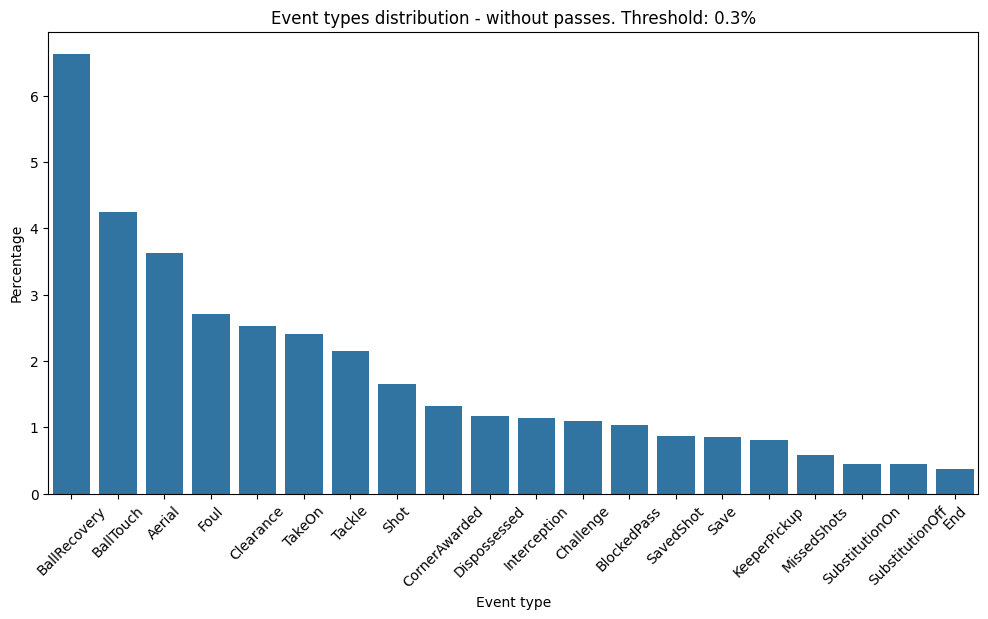

In [11]:
helper_funcs.plot_events_distribution(events)

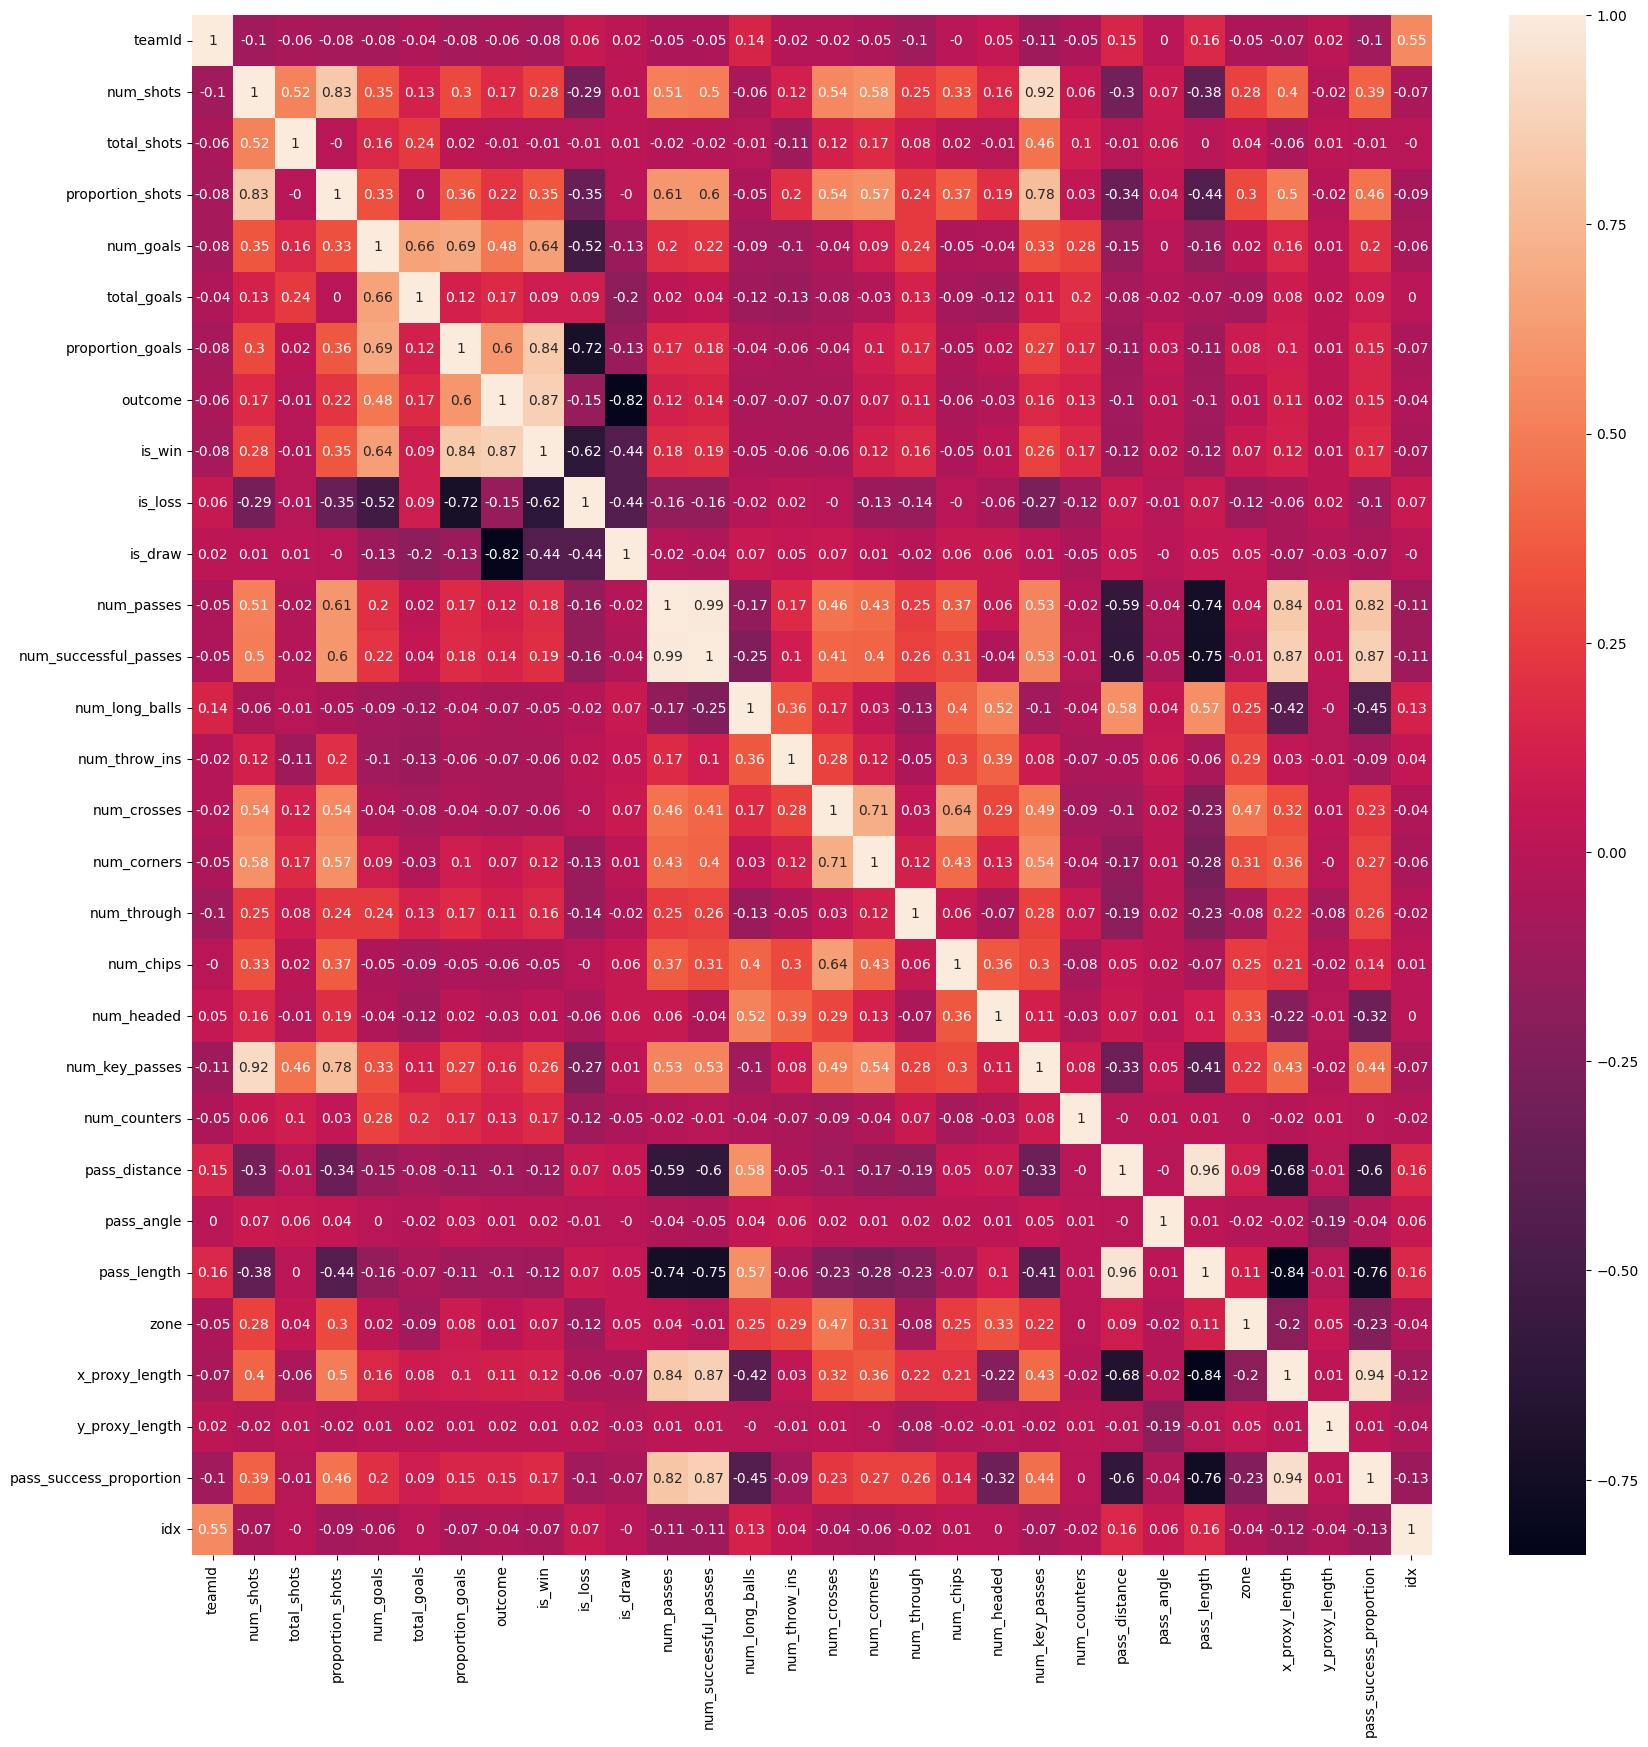

In [12]:
# checking that we haven't missed any correlations
f, ax = plt.subplots(figsize=(20, 20))
corr = stats.drop(columns=['jsonName', 'leagueSeason']).corr().round(2)
sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values, annot=True)
plt.show()

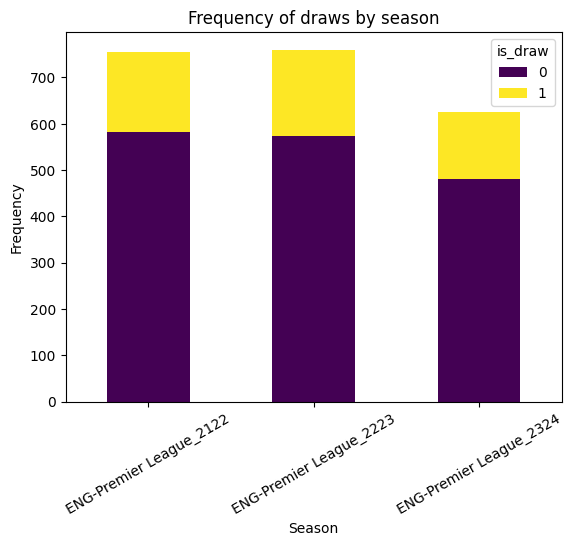

In [13]:
# visualizing outcomes
helper_funcs.plot_outcomes(goals)

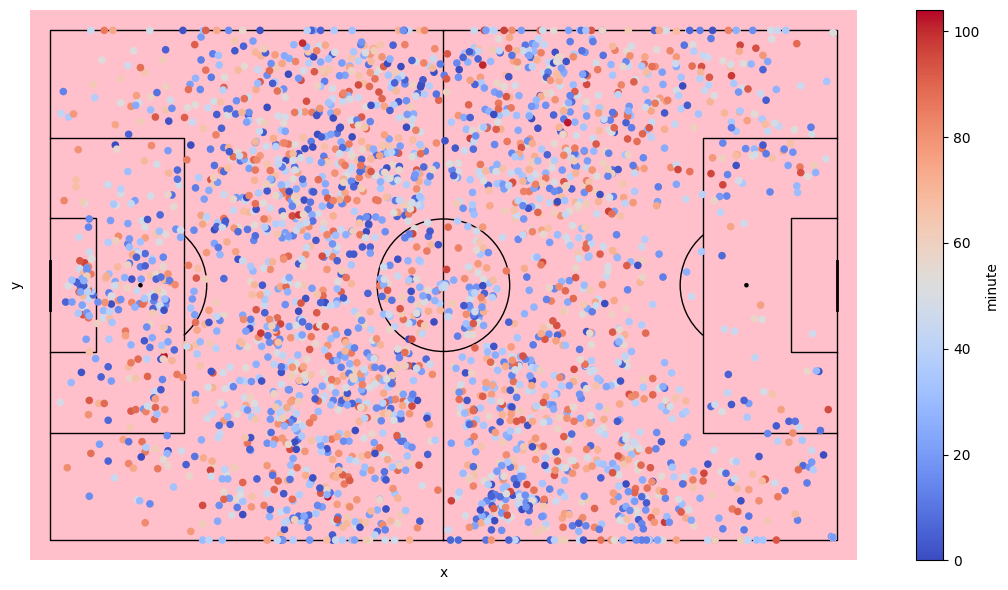

In [14]:
helper_funcs.plot_pass_by_minute(events, n_passes=3000)

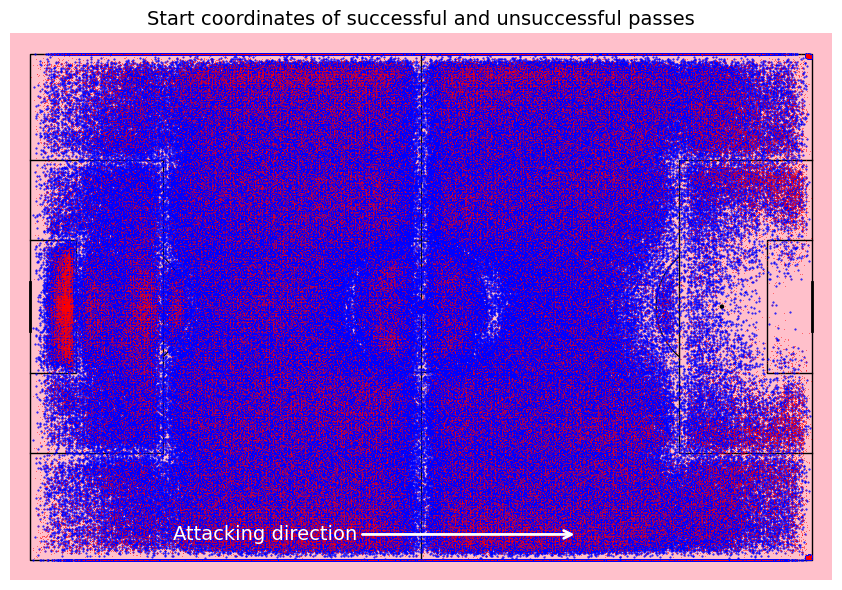

In [15]:
helper_funcs.plot_pass_map(events)

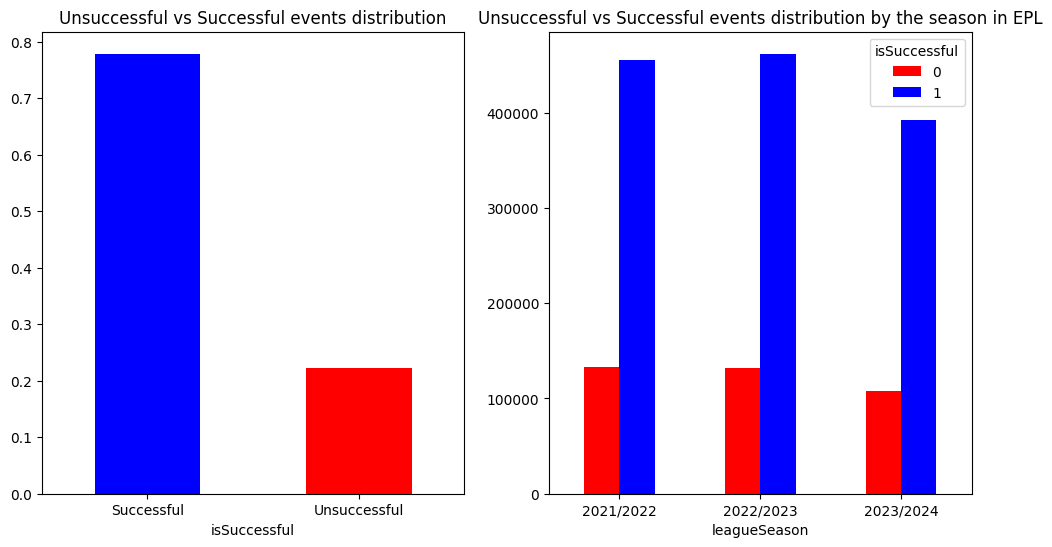

In [16]:
# visualizing successful/unsuccessful passes & passes ratio by leagueSeason
helper_funcs.plot_success_rate(events)

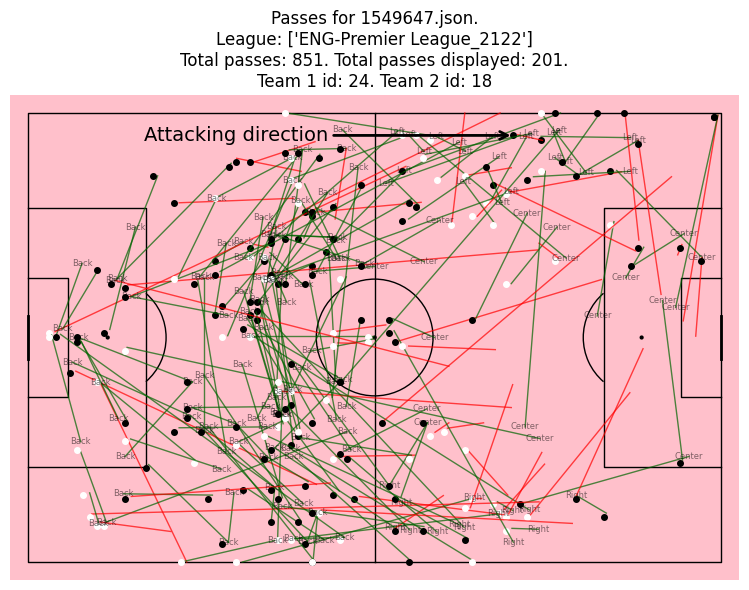

In [17]:
fig, ax = helper_funcs.draw_opta_pitch()

dummy_game = events[events['jsonName'] == passes['jsonName'].unique()[np.random.randint(0, passes['jsonName'].nunique())]]
dummy_game = dummy_game[dummy_game['eventType'] == 'Pass']

total_passes = 0
teams = dummy_game['teamId'].unique()
for i, event in dummy_game.iterrows():
    x = [event['x'], event['endX']]
    y = [event['y'], event['endY']]

    if event['isSuccessful'] == 1:
        ax.plot(x, y, color='darkgreen', linewidth=1, alpha=0.7)
        ax.text(x[-1], y[-1], event['Zone'], fontsize=6, color='black', ha='center', va='center', alpha=0.5)
    else:
        ax.plot(x, y, color='red', linewidth=1, alpha=0.7)
    ax.plot(int(event['x']), int(event['y']), 'o', color='white' if event['teamId'] == teams[0] else 'black', markersize=4)
    total_passes += 1
    
    if total_passes > 200:
        ax.annotate('Attacking direction', xy=(70, 95), xytext=(30, 95), arrowprops=dict(arrowstyle='->', lw=2, color='black'), fontsize=14, color='black', ha='center', va='center')
        plt.title(f'Passes for {event["jsonName"]}.\nLeague: {dummy_game['leagueSeason'].unique()}\nTotal passes: {dummy_game.shape[0]}. Total passes displayed: {total_passes}.\nTeam 1 id: {teams[0]}. Team 2 id: {teams[1]}')
        plt.show()
        break
    

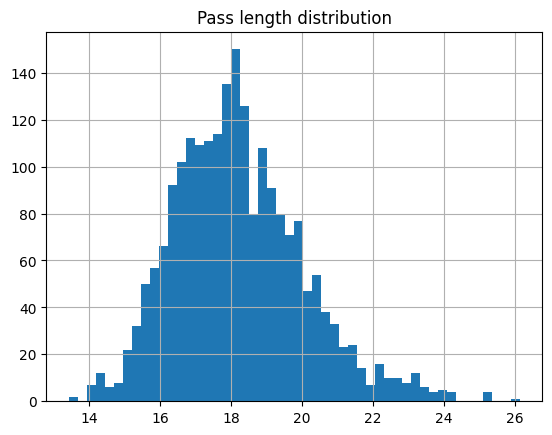

In [18]:
# plot avg pass length
fig, ax = plt.subplots()

passes['pass_length'].hist(bins=50, ax=ax)
plt.title('Pass length distribution')
plt.style.use('tableau-colorblind10')
plt.show()

# model training

In [19]:
sample_dict = {
    'aed' : consolidated_stats, 
    'ncaed' : stats,
    'naed' : events_stats.dropna(subset=['x', 'y', 'endX', 'endY'])}

result_collector = {'model' : [], 
                    'sample' : [],
                    'accuracy' : [], 
                    'precision' : [], 
                    'recall' : [], 
                    'f1' : []}

## LogReg

In [20]:
for sample_name, df in sample_dict.items():
    X_train, X_test, y_train, y_test = models.prep_data(df=df, sample_type=sample_name)

    model = LogisticRegression()

    models.train_model(X_train, y_train, model)
    y_pred = models.evaluate_model(model, X_test, y_test, sample_name)  
    models.collect_statistics(result_collector, model, y_test, y_pred, sample_name)

Accuracy: 0.626. Sample: ('aed',) Model: LogisticRegression.

              precision    recall  f1-score   support

           0       0.33      0.18      0.23        17
           1       0.69      0.79      0.73        47
           2       0.61      0.63      0.62        43

    accuracy                           0.63       107
   macro avg       0.54      0.53      0.53       107
weighted avg       0.60      0.63      0.61       107

Accuracy: 0.575. Sample: ('ncaed',) Model: LogisticRegression.

              precision    recall  f1-score   support

           0       0.20      0.06      0.09        34
           1       0.57      0.67      0.62        90
           2       0.62      0.68      0.65        90

    accuracy                           0.57       214
   macro avg       0.46      0.47      0.45       214
weighted avg       0.53      0.57      0.54       214

Accuracy: 0.58. Sample: ('naed',) Model: LogisticRegression.

              precision    recall  f1-score   supp

## XGB

In [33]:

for sample_name, df in sample_dict.items():
    X_train, X_test, y_train, y_test = models.prep_data(df=df, sample_type=sample_name)
    X = df.drop(columns=modelling_dict[sample_name]['leakage'])
    X = X.select_dtypes(include=['float64', 'int64'])

    model = XGBClassifier()

    models.train_model(X_train, y_train, model)
    y_pred = models.evaluate_model(model, X_test, y_test, sample_name)      
    models.collect_statistics(result_collector, model, y_test, y_pred, sample_name)
    models.print_top_10_features(X, model)

Accuracy: 0.561. Sample: ('aed',) Model: XGBClassifier.

              precision    recall  f1-score   support

           0       0.20      0.18      0.19        17
           1       0.65      0.70      0.67        47
           2       0.59      0.56      0.57        43

    accuracy                           0.56       107
   macro avg       0.48      0.48      0.48       107
weighted avg       0.55      0.56      0.56       107

                      feature  importance_%
32         proportion_shots_1      7.484783
5              num_counters_2      4.616909
6               num_crosses_1      4.113510
7               num_crosses_2      4.062147
16                num_shots_1      3.598168
20              num_through_1      3.171040
31  pass_success_proportion_2      3.126447
30  pass_success_proportion_1      2.958314
22            num_throw_ins_1      2.583890
26            pass_distance_1      2.546778


Accuracy: 0.519. Sample: ('ncaed',) Model: XGBClassifier.

              pre

# RF

In [22]:
for sample_name, df in sample_dict.items():
    X_train, X_test, y_train, y_test = models.prep_data(df=df, sample_type=sample_name)

    model = RandomForestClassifier()

    models.train_model(X_train, y_train, model)
    y_pred = models.evaluate_model(model, X_test, y_test, sample_name)      
    models.collect_statistics(result_collector, model, y_test, y_pred, sample_name)

Accuracy: 0.533. Sample: ('aed',) Model: RandomForestClassifier.

              precision    recall  f1-score   support

           0       0.09      0.06      0.07        17
           1       0.60      0.70      0.65        47
           2       0.56      0.53      0.55        43

    accuracy                           0.53       107
   macro avg       0.42      0.43      0.42       107
weighted avg       0.50      0.53      0.52       107

Accuracy: 0.523. Sample: ('ncaed',) Model: RandomForestClassifier.

              precision    recall  f1-score   support

           0       0.17      0.12      0.14        34
           1       0.54      0.56      0.55        90
           2       0.60      0.64      0.62        90

    accuracy                           0.52       214
   macro avg       0.43      0.44      0.43       214
weighted avg       0.50      0.52      0.51       214

Accuracy: 0.542. Sample: ('naed',) Model: RandomForestClassifier.

              precision    recall  f1

In [29]:
coordinates = events_stats[(events_stats['eventType'] == 'Pass' ) & (events['isSuccessful'] == True) & (events_stats['outcome'] != 0)][['playerId', 'x','y','endX', 'endY', 'zone', 'outcome']]

model = models.SimpleGNNClassification()
data = helper_funcs.df_to_data(coordinates)
loader = DataLoader([data], batch_size=1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.03)
model.train()

for epoch in range(100):
    total_correct = total_samples = 0
    for batch in loader:
        optimizer.zero_grad()
        output = model(batch)
        loss = F.cross_entropy(output, batch.y)
        loss.backward()
        optimizer.step()

        pred = output.max(dim=1)[1]
        correct = pred.eq(batch.y).sum().item()
        total_correct += correct
        total_samples += batch.y.size(0)
    
    
    accuracy = total_correct / total_samples
    precision = precision_score(batch.y, pred, average='weighted')
    recall = recall_score(batch.y, pred, average='weighted')
    f1 = f1_score(batch.y, pred, average='weighted')

    print(f'Epoch: {epoch}, Loss: {loss.item()}, Accuracy: {accuracy}')


result_collector['model'].append('GNN')
result_collector['sample'].append('coordinates')
result_collector['accuracy'].append(accuracy)
result_collector['precision'].append(precision)
result_collector['recall'].append(recall)
result_collector['f1'].append(f1)

Epoch: 0, Loss: 47.64885711669922, Accuracy: 0.46975471544358705
Epoch: 1, Loss: 29.622417449951172, Accuracy: 0.46975471544358705
Epoch: 2, Loss: 12.427519798278809, Accuracy: 0.46975001410401873
Epoch: 3, Loss: 6.771982669830322, Accuracy: 0.5102050410897079
Epoch: 4, Loss: 12.659076690673828, Accuracy: 0.5269183032552075
Epoch: 5, Loss: 15.591212272644043, Accuracy: 0.530245284556413
Epoch: 6, Loss: 15.165369987487793, Accuracy: 0.530245284556413
Epoch: 7, Loss: 12.39458179473877, Accuracy: 0.530245284556413
Epoch: 8, Loss: 8.233193397521973, Accuracy: 0.5274950009089256
Epoch: 9, Loss: 4.191514015197754, Accuracy: 0.5083088341304716
Epoch: 10, Loss: 3.3290205001831055, Accuracy: 0.46632743889825673
Epoch: 11, Loss: 6.620852470397949, Accuracy: 0.4697562825567765
Epoch: 12, Loss: 7.586440563201904, Accuracy: 0.4697562825567765
Epoch: 13, Loss: 6.58428955078125, Accuracy: 0.4697594167831554
Epoch: 14, Loss: 4.048348426818848, Accuracy: 0.469757849669966
Epoch: 15, Loss: 1.48882508277

# model comparison

In [30]:
scores = round(pd.DataFrame(result_collector), 3).sort_values('accuracy', ascending=False)
scores

,model,sample,accuracy,precision,recall,f1
0,LogisticRegression,aed,0.626,0.601,0.626,0.608
2,LogisticRegression,naed,0.580,0.548,0.580,0.557
1,LogisticRegression,ncaed,0.575,0.531,0.575,0.545
3,XGBClassifier,aed,0.561,0.551,0.561,0.555
8,RandomForestClassifier,naed,0.542,0.513,0.542,0.524
5,XGBClassifier,naed,0.536,0.521,0.536,0.527
6,RandomForestClassifier,aed,0.533,0.503,0.533,0.516
10,GNN,coordinates,0.530,0.515,0.530,0.392
7,RandomForestClassifier,ncaed,0.523,0.504,0.523,0.513
4,XGBClassifier,ncaed,0.519,0.527,0.519,0.522
